In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler


In [11]:
df = pd.read_excel("Online_Retail.xlsx")

In [45]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSpend
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [19]:
# Data Cleaning

df.dropna(subset=['CustomerID'], inplace=True)

df["CustomerID"] = df["CustomerID"].astype(int)

f = df[df["Quantity"] > 0]
df = df[df["UnitPrice"] > 0]

df["TotalSpend"] = df["Quantity"] * df["UnitPrice"]

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406789 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406789 non-null  object        
 1   StockCode    406789 non-null  object        
 2   Description  406789 non-null  object        
 3   Quantity     406789 non-null  int64         
 4   InvoiceDate  406789 non-null  datetime64[ns]
 5   UnitPrice    406789 non-null  float64       
 6   CustomerID   406789 non-null  int32         
 7   Country      406789 non-null  object        
 8   TotalSpend   406789 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(4)
memory usage: 29.5+ MB


C:\Users\PANKAJ\AppData\Local\Temp\ipykernel_5164\3885874509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["TotalSpend"] = df["Quantity"] * df["UnitPrice"]
C:\Users\PANKAJ\AppData\Local\Temp\ipykernel_5164\3885874509.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])


# RFM (Recency, Frequency, Monetary) Metrics

In [22]:
# define refrence date
refrence_date = df["InvoiceDate"].max()

In [24]:
# Calculate RFM 
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (refrence_date - x.max()).days,
    "InvoiceNo": "count",    #Frequency
    "TotalSpend": "sum"      # Monetary
}).reset_index()

In [25]:
# Rename colomns
rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]

rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,325,2,0.00
1,12347,1,182,4310.00
2,12348,74,31,1797.24
3,12349,18,73,1757.55
4,12350,309,17,334.40


In [29]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[["Recency", "Frequency", "Monetary"]])

In [30]:
# Optimal K (Elbow method)

wcss = []
for i in range(1, 11):  
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)


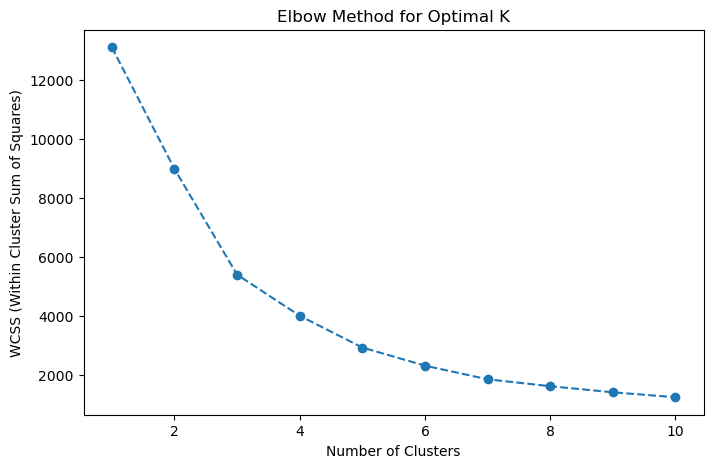

In [34]:
plt.figure(figsize=(8,5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS (Within Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal K")
plt.show()

In [40]:
#K-Means Clustering

# Assume optimal K = 3 (from elbow method)
kmeans = KMeans(n_clusters=3, init="k-means++", random_state=42, n_init=10)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)

rfm.head()


,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346,325,2,0.00,0
1,12347,1,182,4310.00,1
2,12348,74,31,1797.24,1
3,12349,18,73,1757.55,1
4,12350,309,17,334.40,0


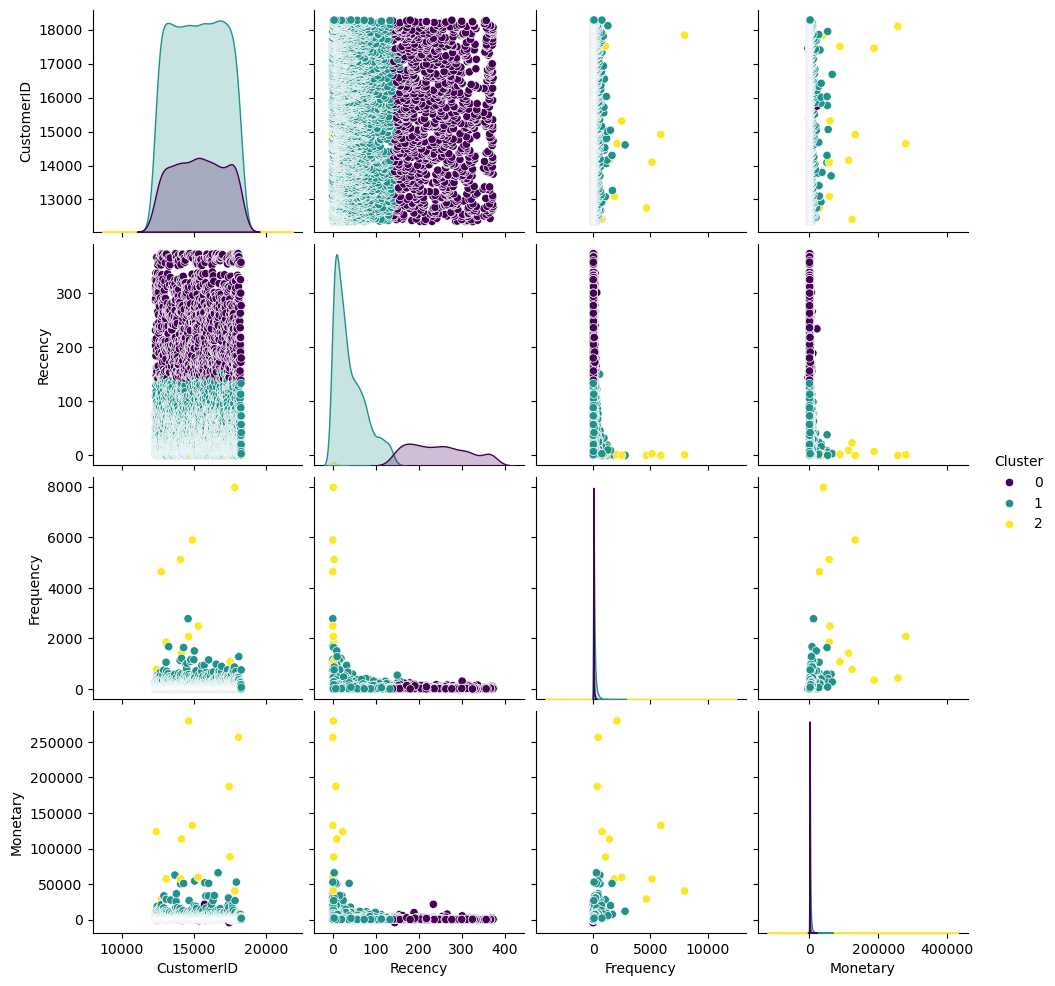

In [41]:
sns.pairplot(rfm, hue="Cluster", palette="viridis")
plt.show()


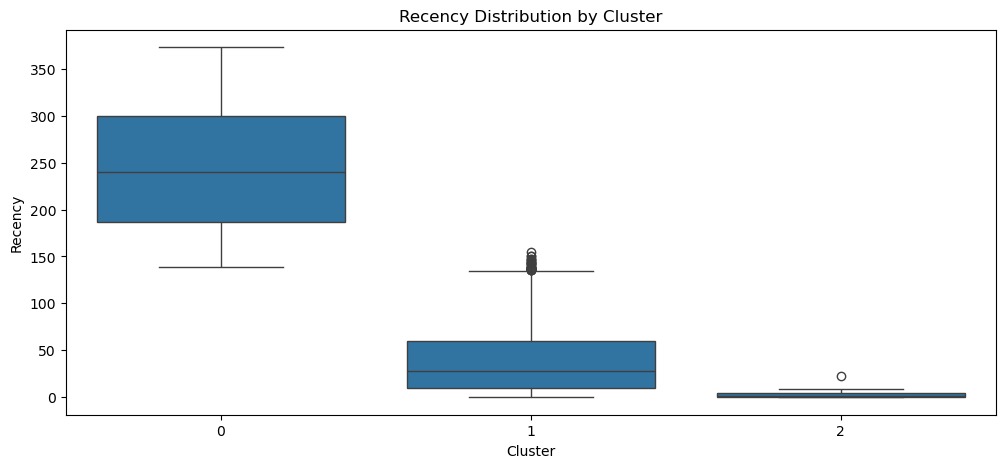

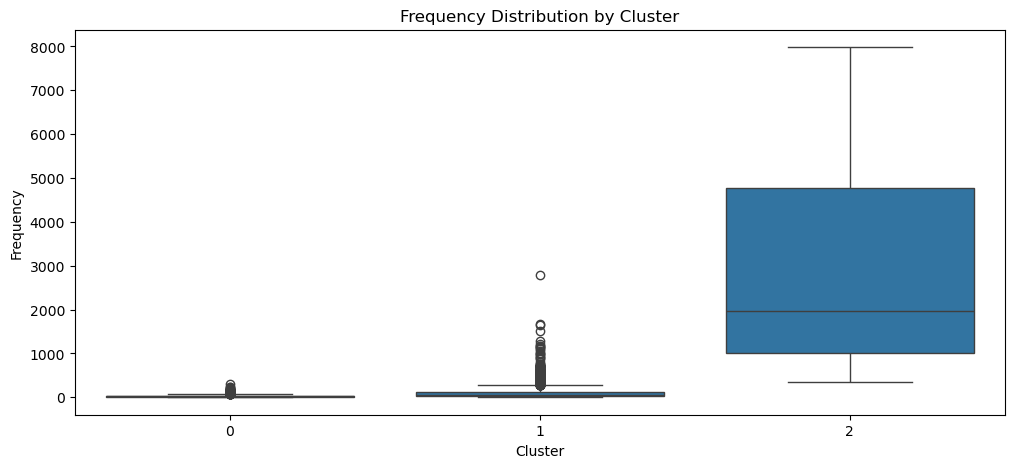

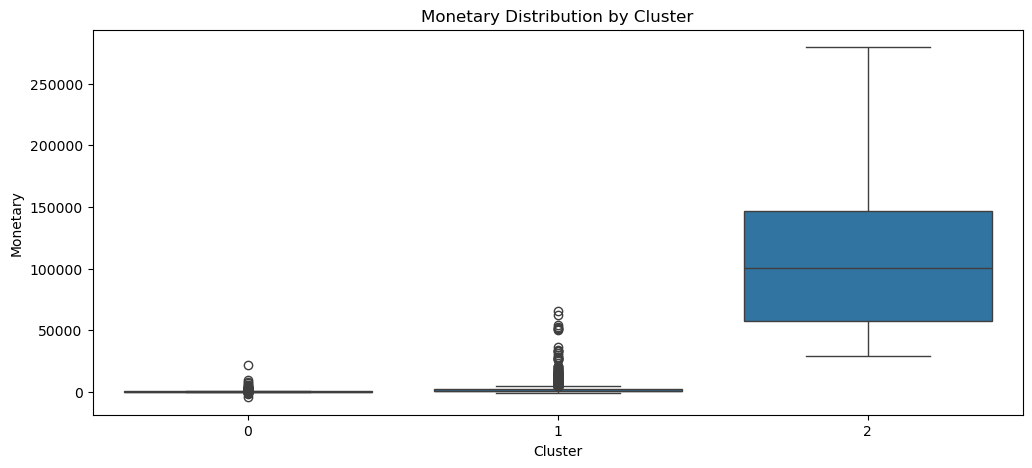

In [42]:
plt.figure(figsize=(12, 5))
sns.boxplot(x="Cluster", y="Recency", data=rfm)
plt.title("Recency Distribution by Cluster")
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(x="Cluster", y="Frequency", data=rfm)
plt.title("Frequency Distribution by Cluster")
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(x="Cluster", y="Monetary", data=rfm)
plt.title("Monetary Distribution by Cluster")
plt.show()
